In [1]:
from fastai.vision.all import *

In [2]:
base_path = Path('src')

img_train = base_path / 'train_images'
img_test = base_path / 'test_images'

In [3]:
df_train = pd.read_csv(base_path / 'train.csv')
df_test = pd.read_csv(base_path / 'test.csv')

Add the path to the image-file.

In [4]:
df_train['image'] = df_train['image'].apply(lambda x: img_train / x)

In [5]:
print(f'Unique images: {df_train.image_phash.nunique()} of {df_train.image.nunique()} unique image-files.')

Unique images: 28735 of 32412 unique image-files.


Drop duplicate image_phash.

In [6]:
df_train.drop_duplicates(['image_phash'], inplace = True)

In [7]:
df_groupby_label = df_train.groupby(['label_group'])['image_phash'].nunique().to_frame()

In [8]:
print(f'Number of labels, that contain only one image_phash: {(df_groupby_label.image_phash < 2).sum()}')

Number of labels, that contain only one image_phash: 1039


Only keep instances that belong to a label_group that contains more than one image_phash.

In [9]:
keep_labels = df_groupby_label[df_groupby_label.image_phash >= 2].index.tolist()
df_train = df_train[df_train['label_group'].isin(keep_labels)].reset_index(drop = True)

In [10]:
# Sanity check:
print(f"Number of labels, that contain only one image_phash: {(df_train.groupby(['label_group'])['image_phash'].nunique() < 2).sum()}")
print(f"Number of duplicate files: {df_train.duplicated(['image']).sum()}")

Number of labels, that contain only one image_phash: 0
Number of duplicate files: 0


We can now make shure to draw image-files with different phashes, when creating the Siamese dataset.

## create smaller dataset

In [11]:
small_pct = 0.1

In [12]:
x = df_train['label_group'].unique()
y = np.random.choice(x, size = int(len(x)*small_pct), replace = False)
df_train = df_train[df_train['label_group'].isin(y)]
df_train = df_train.reset_index(drop = True)

In [13]:
df_train.head()

,posting_id,image,image_phash,title,label_group
0,train_1598329973,src/train_images/001d7f5d9a2fac714f4d5f37b3baffb4.jpg,bec8d09693634b4b,Atasan Rajut Wanita LISDIA SWEATER,2462407944
1,train_2496690777,src/train_images/001e11145b8e9bf5ac51110c0fdd8697.jpg,eab5c295966ac368,PASHMINA KUSUT RAWIS POLOS CRINKLE SHAWL MURAH BANGET,509010932
2,train_998568945,src/train_images/001f4c8331d0554d133b10d85b7fafb2.jpg,d8a6082bb93d2db5,Lampu led t5 Speedometer Dashboard Motor Mobil 5050 Speedo Bright,4206465630
3,train_2985955659,src/train_images/002f978c58a44a00aadfca71c3cad2bb.jpg,bf38f0e083d7c710,HnKfashion Sweater Hoodie WHO Printing BabyTerry - Fit L,3415582503
4,train_2238403912,src/train_images/003524b70715bf6bfa00451ca08e66e0.jpg,ba35c44a3fb7c068,Kangaroo Teflon / Allu Fry Pan 18 cm - KG652,531768918


In [14]:
def open_image(fname, size=224):
    img = Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [15]:
def split_by_label(df):
    # L-list of unique labels
    labels = L(df.label_group.unique().tolist())
    # Randomly split labels
    split_labels = RandomSplitter(valid_pct=0.2)(labels)  # Returns 80/20 split of labels

    # Mask labels to receive train/val labels
    train_labels = labels[split_labels[0]]
    validation_labels = labels[split_labels[1]]

    # Add colum to mark file as a part of the training/validation set
    df['is_valid'] = df_train.label_group.isin(validation_labels)

    # Sanity check:
    assert((df.groupby(['label_group'])['is_valid'].nunique() > 1).sum() == 0)
    
    files = L(df['image'].tolist())
    train_idx = df[df['is_valid'] == False].index.tolist()
    validation_idx = df[df['is_valid'] == True].index.tolist()
    
    # Sanity check:
    assert(set(files[train_idx]) == set(df[df['is_valid'] == False]['image']))
    assert(set(files[validation_idx]) == set (df[df['is_valid'] == True]['image']))
    
    return files, train_labels, validation_labels, train_idx, validation_idx

In [16]:
files, train_labels, validation_labels, train_split, val_split = split_by_label(df_train)
splits = (train_split, val_split)
labels = (train_labels,validation_labels)

In [17]:
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

In [18]:
splbl2files = [(df_train.loc[splits[i]]).groupby(['label_group'])['image'].apply(list).to_dict() for i in range(2)]

In [19]:
def get_split(f):
    for i,s in enumerate(splits_sets):
        if f in s:
            return i
    raise ValueError(f'File {f} is not presented in any split.')

In [20]:
def label_func(f):
    return df_train[df_train['image'] == f]['label_group'].values[0]

In [56]:
#class SiameseImage(fastuple):
#    def show(self, ctx=None, **kwargs): 
#        if len(self) > 2:
#            img1,img2,similarity = self
#        else:
#            img1,img2 = self
#            similarity = 'Undetermined'
#        if not isinstance(img1, Tensor):
#            if img2.size != img1.size: 
#                img2 = img2.resize(img1.size)
#            t1,t2 = tensor(img1),tensor(img2)
#            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
#        else: 
#            t1,t2 = img1,img2
#        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
#        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

In [55]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

<AxesSubplot:title={'center':'False'}>

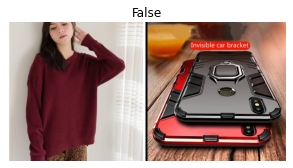

In [22]:
img1 = PILImage.create(files[0])
img2 = PILImage.create(files[154])
s = SiameseImage(img1, img2, False)
s.show()

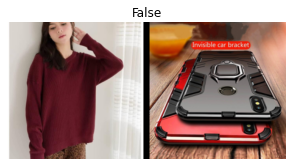

In [23]:
tst = Resize(224)(s)
tst = ToTensor()(tst)
tst.show();

In [67]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [(df_train.loc[splits[i]]).groupby(['label_group'])['image'].apply(list).to_dict() for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
        
        
    def encodes(self, f):
        f2, same = self.valid.get(f, self._draw(f, 0))
        img1, img2 = PILImage.create(f), PILImage.create(f2)
        
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f, split = 0):
            same = random.random() < 0.5

            cls = label_func(f)
            split = get_split(f)

            if not same:
                cls = random.choice([l for l in labels[split] if l != cls])

            return random.choice([f2 for f2 in self.splbl2files[split][cls] if f2 != f]),int(same)

In [90]:
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits = splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
                      bs = 2
                     )

In [91]:
b = dls.one_batch()
type(b)

__main__.SiameseImage

In [92]:
b[2]

tensor([1, 1], device='cuda:0')

In [93]:
@typedispatch
def show_batch(x:SiameseImage, 
               y, 
               samples, 
               ctxs=None, 
               max_n=6, 
               nrows=None, 
               ncols=2, 
               figsize=None, 
               **kwargs
              ):
    if figsize is None: 
        figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: 
        ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

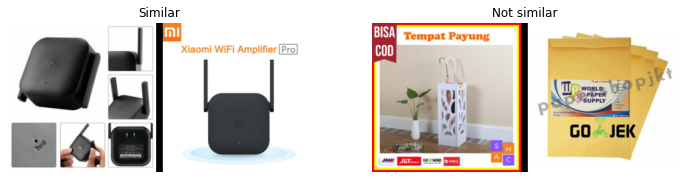

In [94]:
dls.show_batch()

In [95]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [96]:
encoder = create_body(resnet34, cut=-2)

In [97]:
head = create_head(512*2, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [98]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [99]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [100]:
learn = Learner(dls,
                model,
                loss_func = loss_func,
                splitter = siamese_splitter,
                metrics = accuracy
               )

In [101]:
learn.freeze()

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=1.4454397387453355e-05)

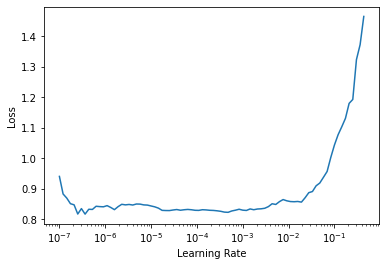

In [80]:
learn.lr_find()

In [102]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.852172,0.761291,0.484288,00:59


In [113]:
@typedispatch
def show_results(x:SiameseImage, 
                 y, 
                 samples, 
                 outs, 
                 ctxs=None, 
                 max_n=6, 
                 nrows=None, 
                 ncols=2, 
                 figsize=None, 
                 **kwargs                
                ):
    if figsize is None: 
        figsize = (ncols*6, max_n//ncols * 3)
        
    if ctxs is None: 
        ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
        
    for i,ctx in enumerate(ctxs):
        #print(x)
        print(i)
        print(y[0][i])
        print('apple')
        print(y[1][i])
        print('banana')
        print(y[2][i])
        title = f'Actual: {["Not similar","Similar"][int(x[2][i].item())]} \n Prediction: {["Not similar","Similar"][y[2][i].argmax().item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

0
TensorImage([[[ 13,  13,  13,  ...,  13,  13,  13],
         [ 13,  13,  13,  ...,  13,  13,  13],
         [ 13,  13,  13,  ...,  13,  13,  13],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[ 13,  13,  13,  ...,  13,  13,  13],
         [ 13,  13,  13,  ...,  13,  13,  13],
         [ 13,  13,  13,  ...,  13,  13,  13],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[ 13,  13,  13,  ...,  13,  13,  13],
         [ 13,  13,  13,  ...,  13,  13,  13],
         [ 13,  13,  13,  ...,  13,  13,  13],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]])
apple
TensorImage([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 

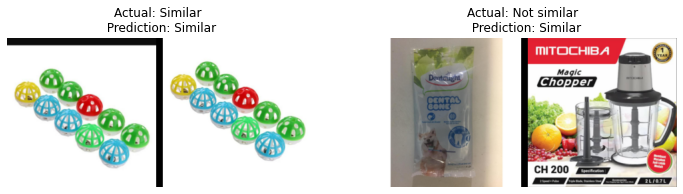

In [114]:
learn.show_results()

In [42]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

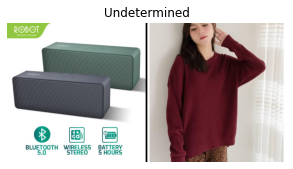

In [43]:
imgtest = PILImage.create(files[0])
imgval = PILImage.create(files[100])
siamtest = SiameseImage(imgval, imgtest)
siamtest.show();

In [44]:
res = learn.siampredict(siamtest)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [84]:
A = learn.dls[1].new()
B = A.one_batch()
C = learn.get_preds(dl = [B], with_decoded = True)

In [85]:
B[2]

tensor([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')